<a href="https://colab.research.google.com/github/VardanDavtyan/ML-DL/blob/main/AutoAm_PricePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

sns.set(rc = {'figure.figsize': (20, 20)})

In [ ]:
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
data = data.dropna()
test_data = test_data.dropna()

In [ ]:
def convert_to_numerical(data):
  km_condition = data['running'].str[-1] == 'm'
  mile_condition = data["running"].astype(str).str[-1] == "s"
  data.loc[km_condition, 'running'] = data.loc[km_condition, 'running'].str.replace(' km', '').str.replace(',', '').astype(np.float32)
  data.loc[mile_condition, 'running'] = data.loc[mile_condition, 'running'].str.replace(' miles', '').str.replace(',', '').astype(np.float32) * 1.6
  return data

data = convert_to_numerical(data)
test_data = convert_to_numerical(test_data)

## Data Analysis

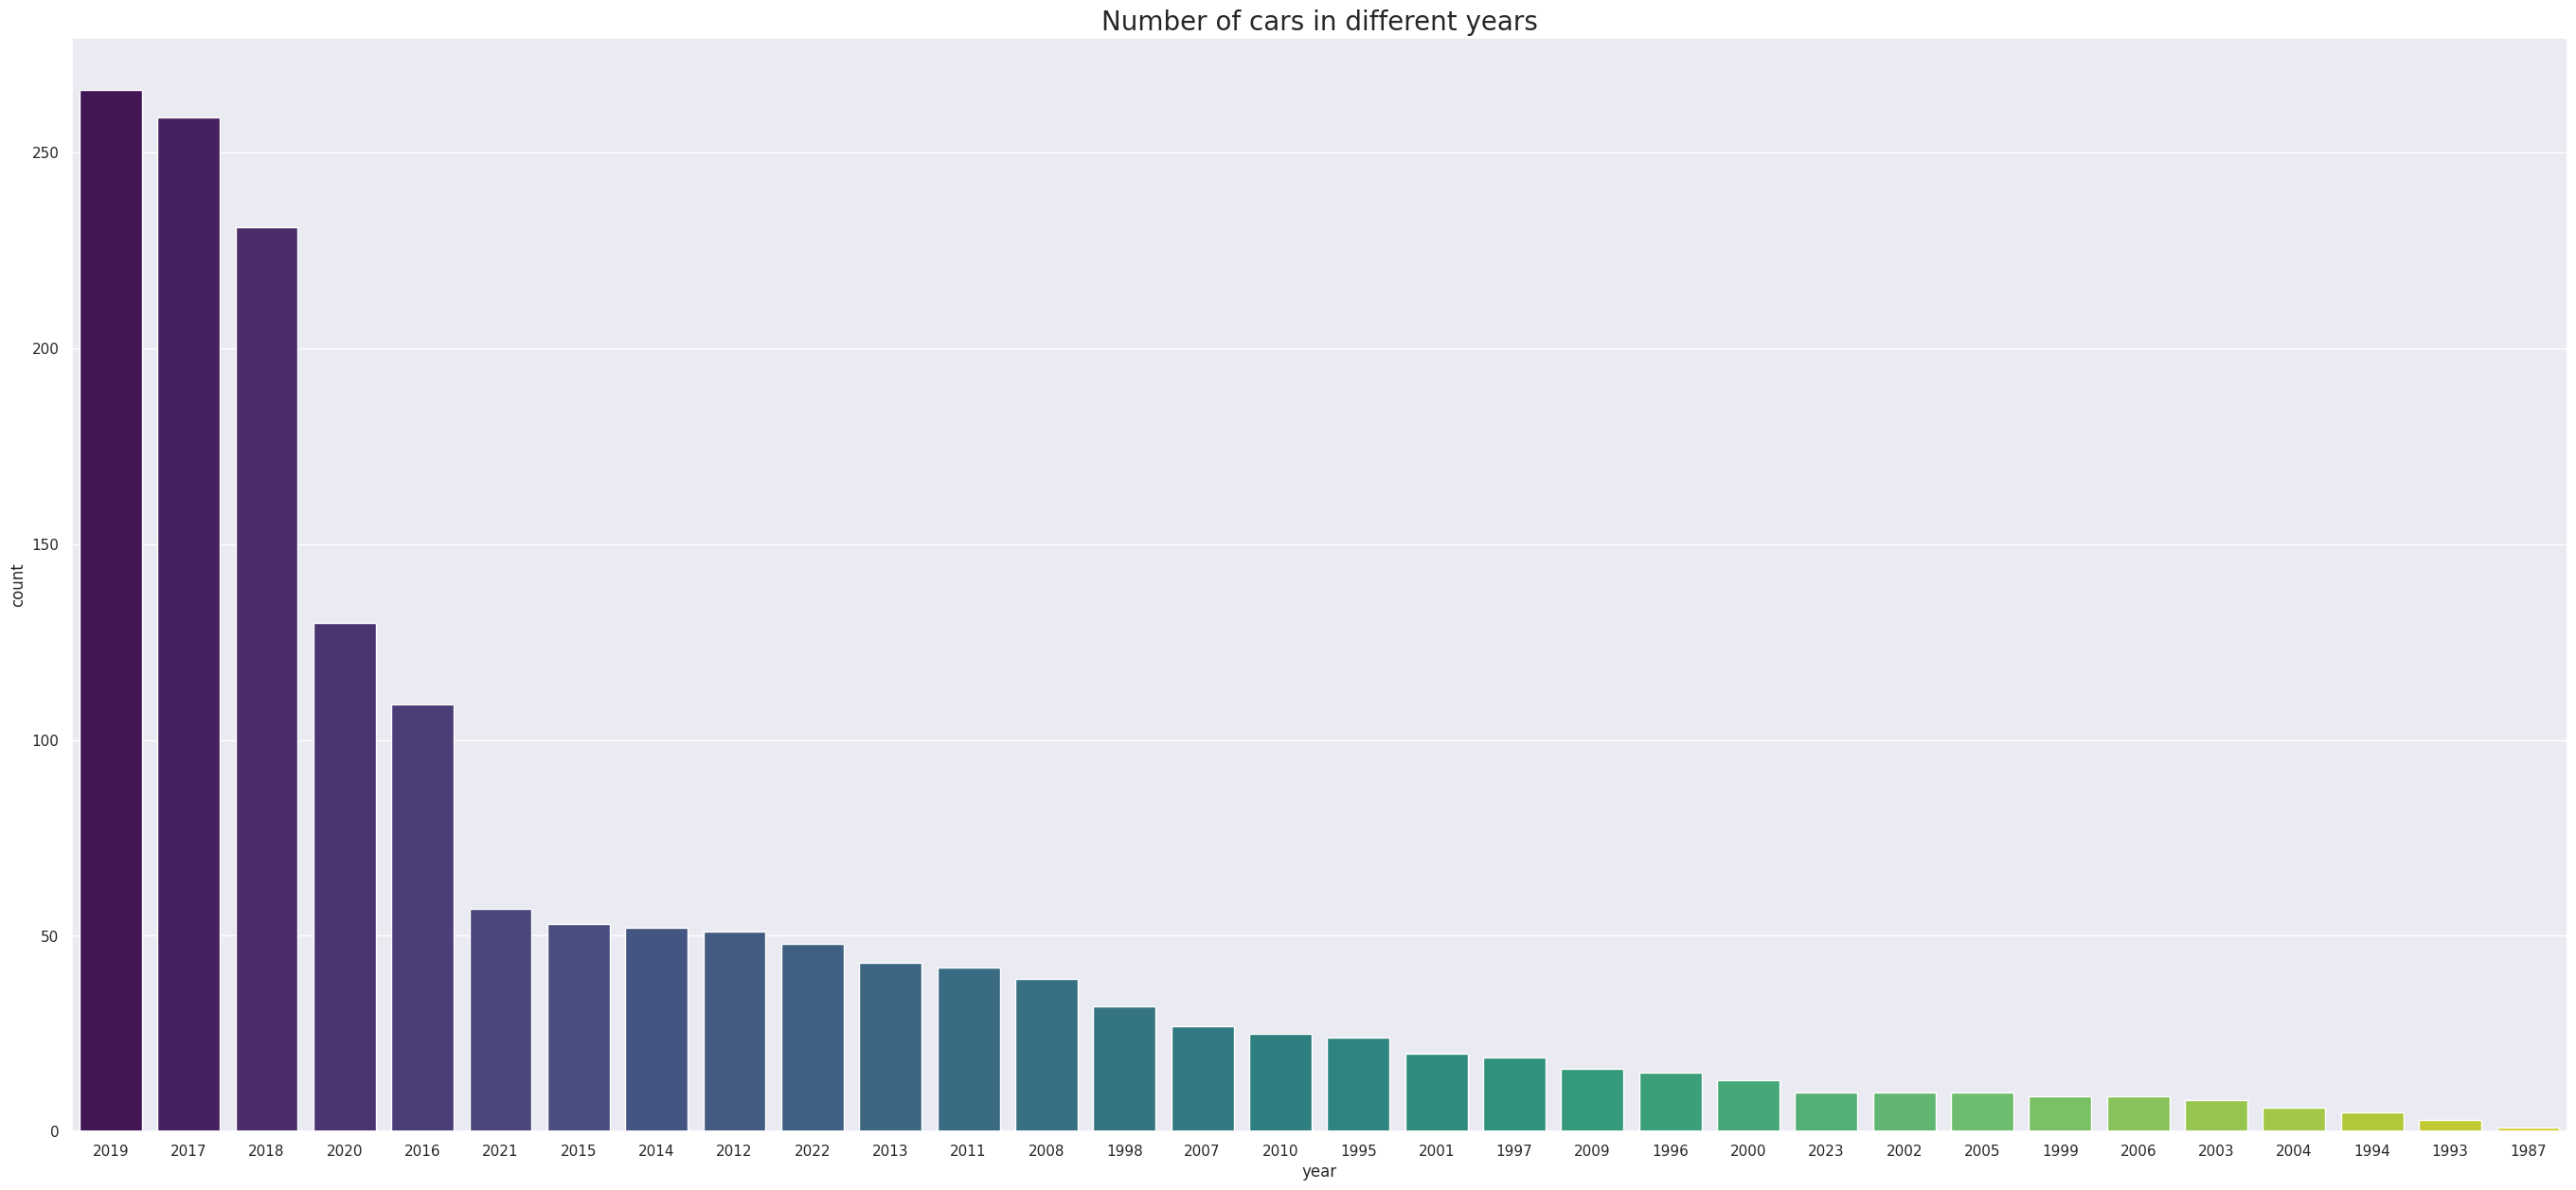

In [ ]:
data['year'] = data['year'].astype(int)
plt.figure(figsize = (34, 15))
sns.countplot(data, x="year", order=data['year'].value_counts().index, palette='viridis')
plt.title("Number of cars in different years", fontsize = 20)
plt.show()

<Axes: >

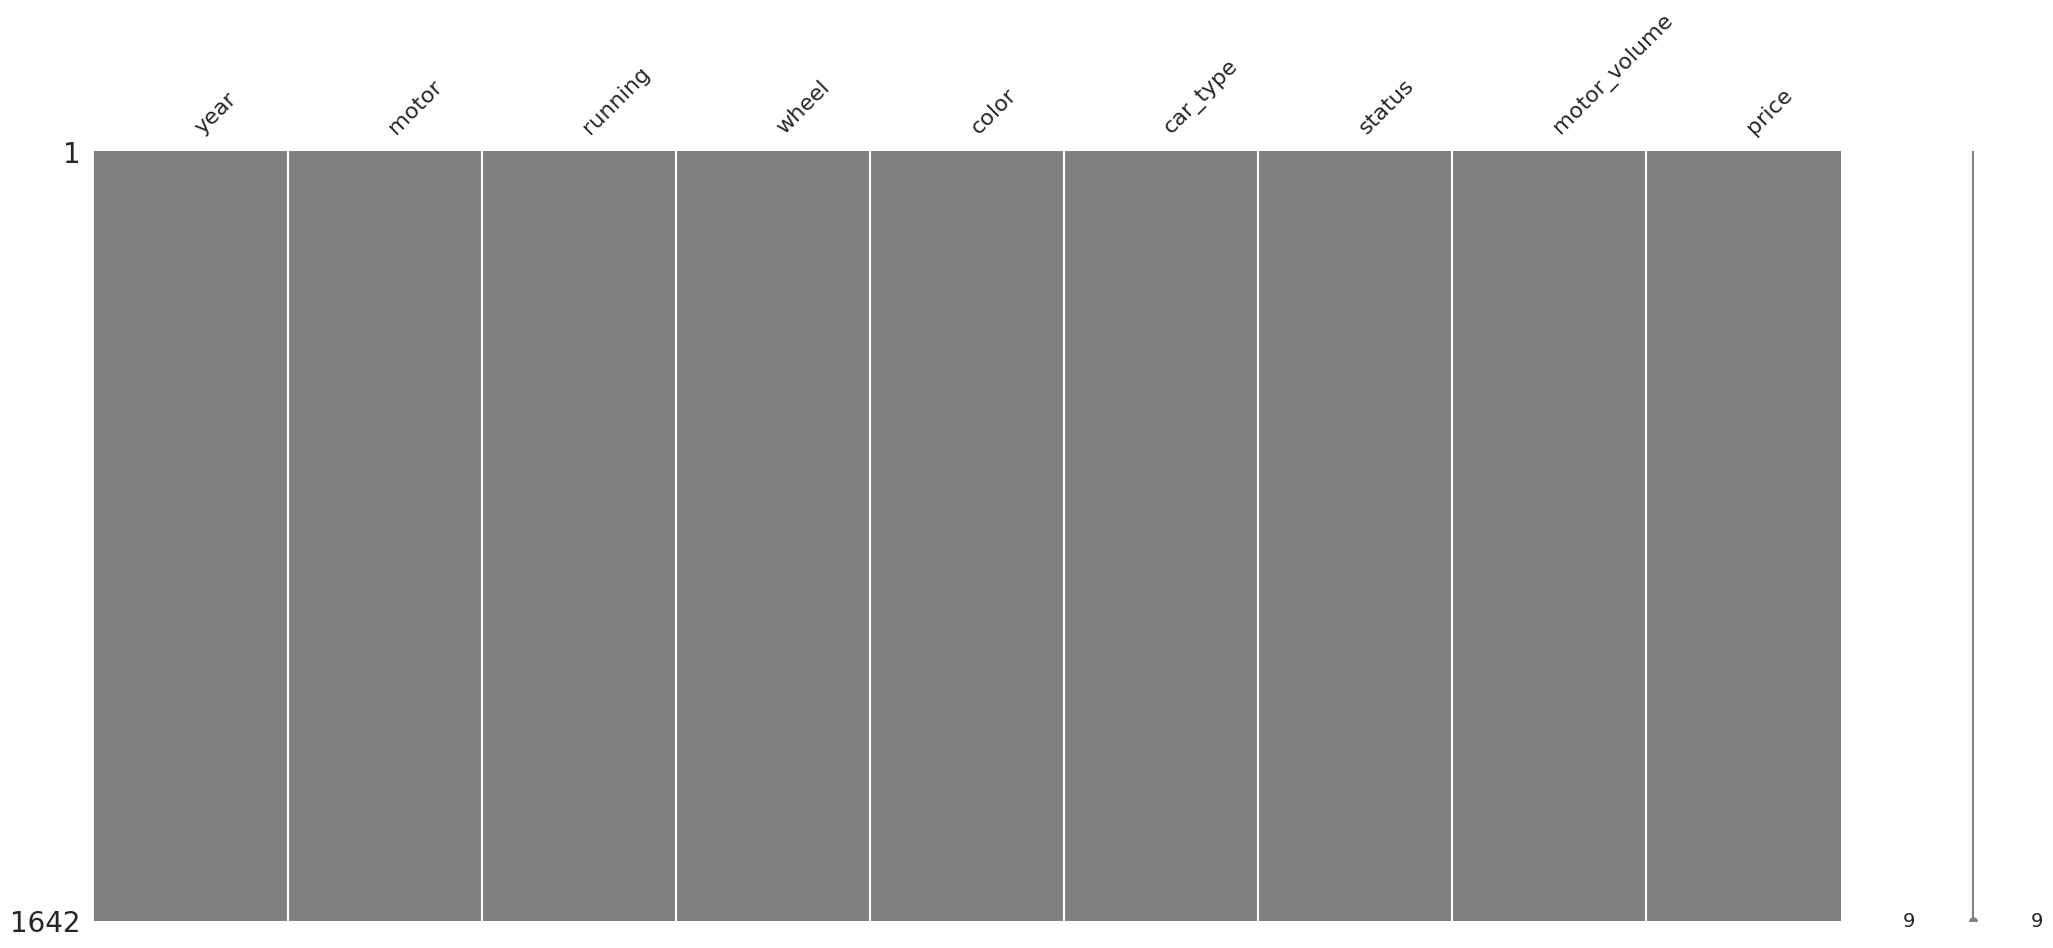

In [ ]:
msno.matrix(data, color = (0.5, 0.5, 0.5))

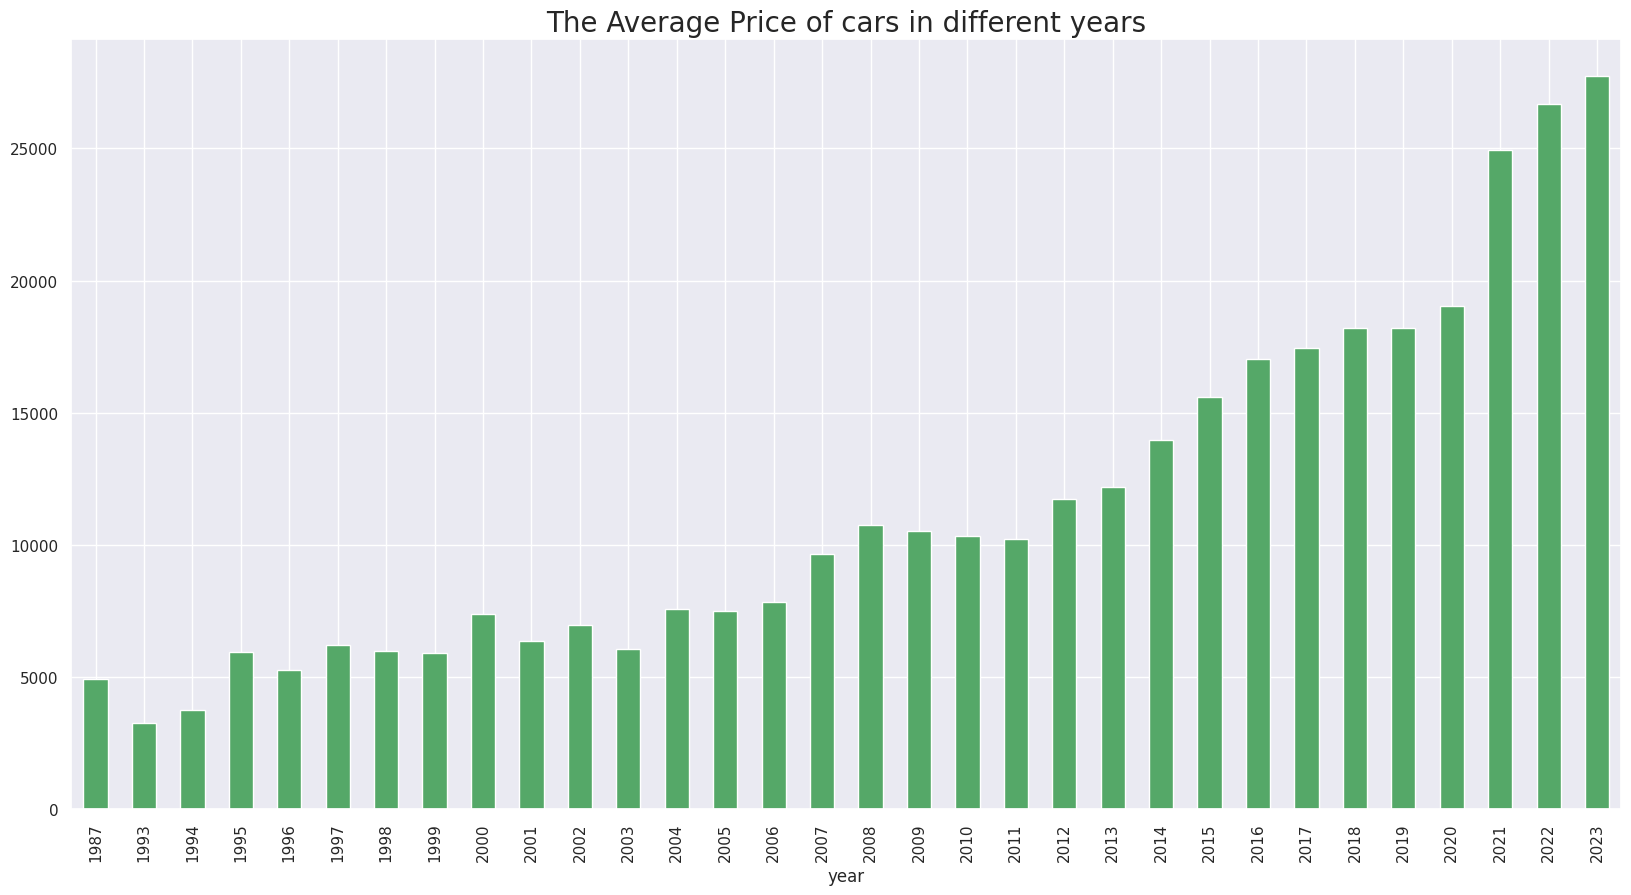

In [ ]:
plt.figure(figsize = (20, 10))
data.groupby('year')['price'].mean().plot(kind = 'bar', color = 'g')
plt.title("The Average Price of cars in different years", fontsize = 20)
plt.show()

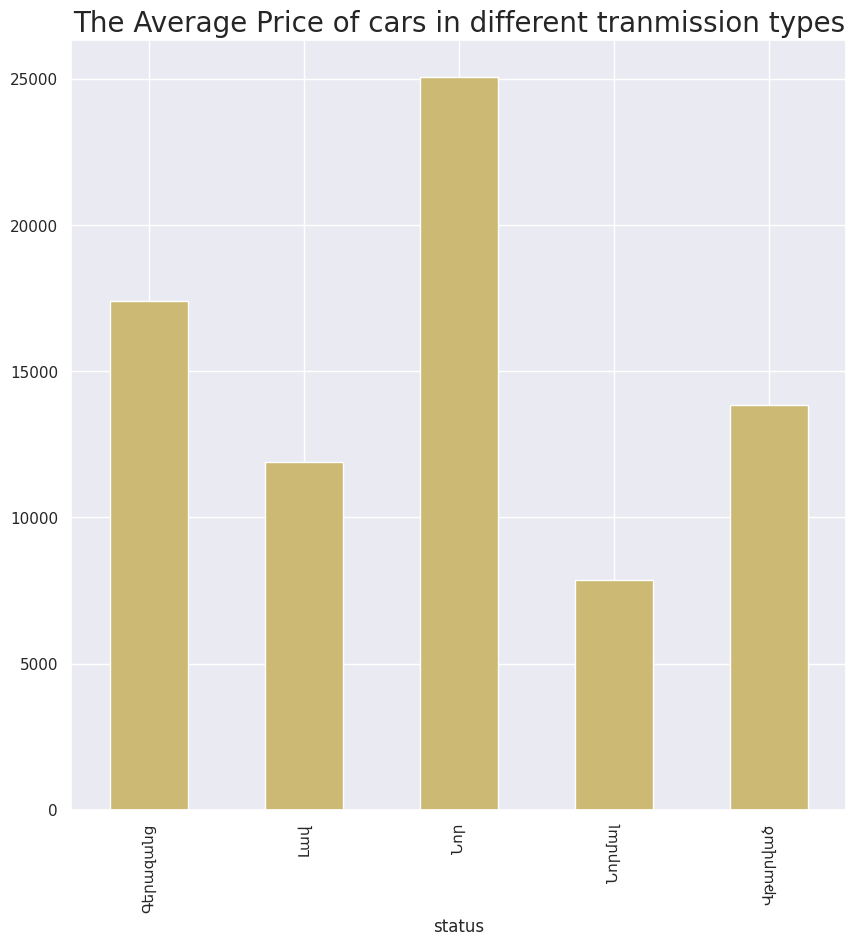

In [ ]:
plt.figure(figsize = (10, 10))
data.groupby('status')['price'].mean().plot(kind = 'bar', color = 'y')
plt.title("The Average Price of cars in different tranmission types", fontsize = 20)
plt.show()

<ipython-input-15-9a292316f187>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap_data = data[numeric_columns].corr()


<Axes: >

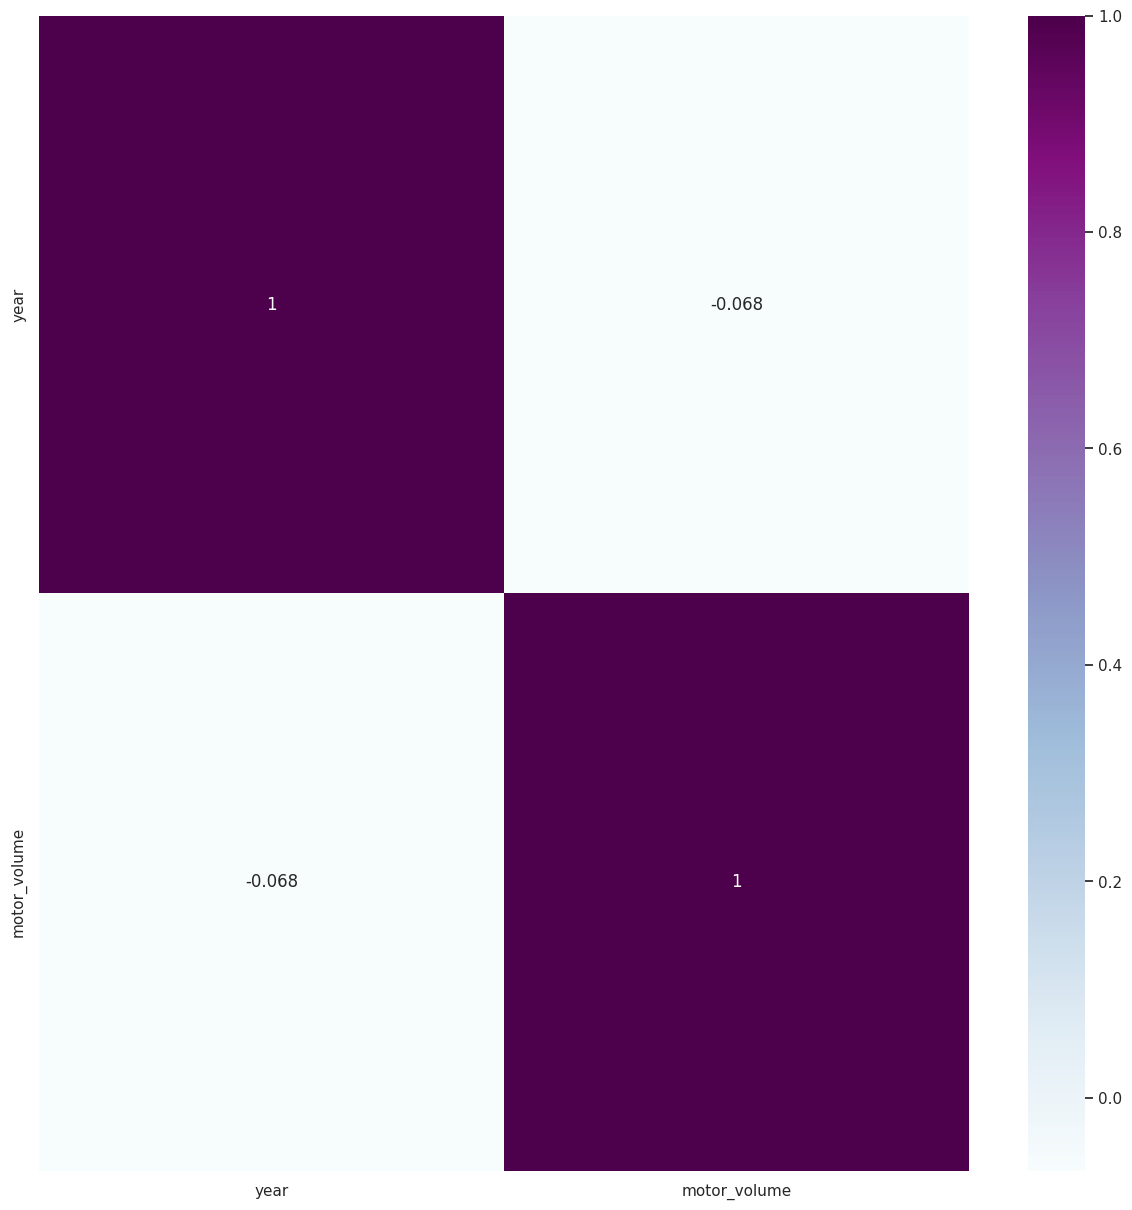

In [ ]:
plt.figure(figsize = (15, 15))
numeric_columns = ['year', 'running', 'motor_volume']
heatmap_data = data[numeric_columns].corr()

sns.heatmap(heatmap_data, cmap = 'BuPu', annot = True)

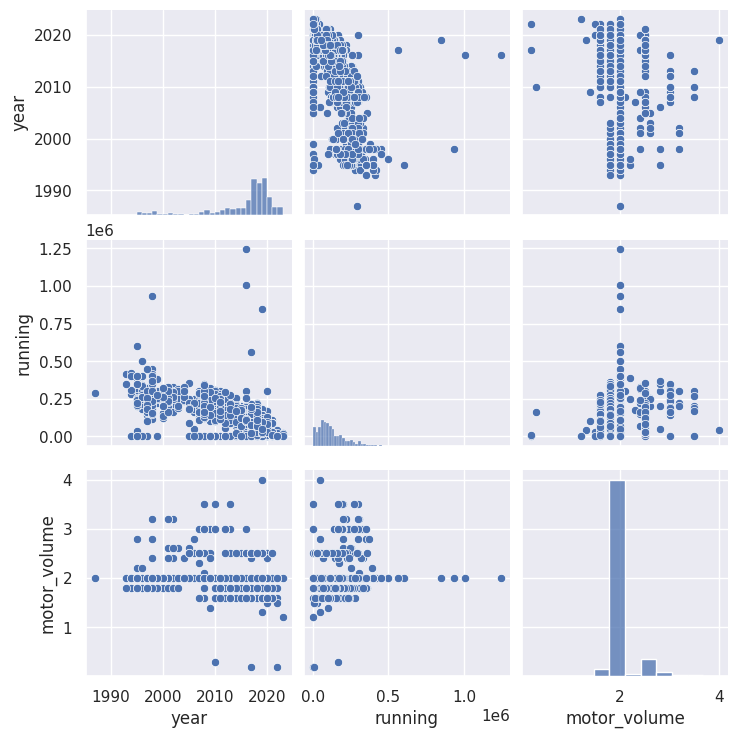

In [ ]:
sns.pairplot(data[numeric_columns])

## Data Processing

In [ ]:
X_train = data.drop('price', axis=1)
y_train = data['price']

X_test = test_data

In [ ]:
X_train['Present Year'] = 2023
X_train['year'] = X_train['Present Year'] - X_train['year']
X_train.drop(['Present Year'], inplace = True, axis = 1)

X_test['Present Year'] = 2023
X_test['year'] = X_test['Present Year'] - X_test['year']
X_test.drop(['Present Year'], inplace = True, axis = 1)

In [ ]:
####################################
columns_to_remove = [
    'color'
]

X_train.drop(columns=columns_to_remove, inplace=True)
X_test.drop(columns=columns_to_remove, inplace=True)
####################################

In [ ]:
encoder = OneHotEncoder()
categorical_features = [
    'model',
    'motor_type',
    #'color',
    'type',
    'status'
]
encoder.fit(X_train[categorical_features])
one_hot_encoded_output_train = encoder.transform(X_train[categorical_features])
X_train.drop(columns=categorical_features, axis=1, inplace=True)
X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)

In [ ]:
one_hot_encoded_output_test = encoder.transform(X_test[categorical_features])
X_test.drop(columns=categorical_features, axis=1, inplace=True)
X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)

In [ ]:
X_test.drop(columns=['Id'], axis=1, inplace=True)

In [ ]:
X_train['wheel'] = X_train['wheel'].apply(lambda x: 1 if x == 'Ձախ' else 0)
X_test['wheel'] = X_test['wheel'].apply(lambda x: 1 if x == 'Ձախ' else 0)

In [ ]:
scaler = MinMaxScaler()
numeric_columns = [
    'year',
    'motor_volume',
    'running']
scaler.fit(X_train[numeric_columns])
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])

In [ ]:
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [ ]:
X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train).astype('float32')

X_test = np.array(X_test).astype('float32')

In [ ]:

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(200, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5000, batch_size=32)


In [ ]:
###############################################################################################
from sklearn.model_selection import KFold

# Assuming you have X and y (features and target) as NumPy arrays

# Define the K-fold cross-validation split
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store results
all_scores = []

# Define your model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(200, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Perform k-fold cross-validation
for train_index, test_index in kfold.split(X_train):
    _X_train, X_test = X_train[train_index], X_train[test_index]
    _y_train, y_test = y_train[train_index], y_train[test_index]

    # Fit the model
    model.fit(_X_train, _y_train, epochs=3000, batch_size=32, verbose=0)

    # Evaluate the model on the test set
    scores = model.evaluate(X_test, y_test, verbose=0)
    all_scores.append(scores)

# Print the average scores
average_loss = np.mean([score[0] for score in all_scores])
average_accuracy = np.mean([score[1] for score in all_scores])
print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')
###############################################################################################

Average Loss: 10992352.15, Average Accuracy: 0.0


In [ ]:
model.save('car_price_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('car_price_model.h5')

In [ ]:
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Mean Absolute Error on Test Set: {mae}')

52/52 [==============================] - 0s 2ms/step
Mean Absolute Error on Test Set: 1055.9107666015625


In [ ]:
df = pd.DataFrame({'Predicted': y_pred.reshape(y_pred.shape[0]), 'Actual': y_train, 'Error': y_train - y_pred.reshape(y_pred.shape[0])})
df

,Predicted,Actual,Error
0,30386.896484,24500.0,-5886.896484
1,21911.457031,25500.0,3588.542969
2,13583.603516,11700.0,-1883.603516
3,11847.117188,12000.0,152.882812
4,29862.712891,26000.0,-3862.712891
...,...,...,...
1637,12105.371094,12400.0,294.628906
1638,14456.977539,16500.0,2043.022461
1639,19068.431641,19500.0,431.568359
1640,19120.523438,19500.0,379.476562


In [ ]:

car_ids = pd.read_csv('test.csv')['Id']
predicted = model.predict(X_test)
predicted = predicted.reshape(predicted.shape[0])

13/13 [==============================] - 0s 2ms/step


In [ ]:
df = pd.DataFrame({'Id': car_ids, 'price': predicted})

In [ ]:
df.to_csv('sample_submission.csv', index=False)

In [ ]:
pd.read_csv('sample_submission.csv')

,Id,price
0,0,17673.078
1,1,16294.873
2,2,24094.662
3,3,14780.211
4,4,19757.064
...,...,...
406,406,38907.305
407,407,14566.518
408,408,14193.885
409,409,16830.084
